# 🔍 GradCAM from Scratch: Complete Implementation & Understanding

## Table of Contents
1. [Introduction & Theory](#intro)
2. [Setup & Dependencies](#setup)
3. [Load & Inspect Model](#model)
4. [Understanding Forward Hooks (Activations)](#activations)
5. [Understanding Backward Hooks (Gradients)](#gradients)
6. [Complete GradCAM Implementation](#implementation)
7. [Advanced Visualizations](#advanced)
8. [Multi-Layer Analysis](#multilayer)
9. [Interactive Experiments](#experiments)

---

## What is GradCAM?

**Gradient-weighted Class Activation Mapping (GradCAM)** is a technique for producing visual explanations for decisions from CNN-based models.

### The Formula:

$$L^c_{GradCAM} = ReLU\left(\sum_k \alpha^c_k A^k\right)$$

Where:
- $A^k$: Activation maps from a convolutional layer
- $\alpha^c_k = \frac{1}{Z}\sum_i \sum_j \frac{\partial y^c}{\partial A^k_{ij}}$: Importance weights (global average pooled gradients)
- $y^c$: Score for class $c$ before softmax
- $ReLU$: Only keeps positive influences

### Why Does It Work?
1. **Activations** capture what the network sees
2. **Gradients** tell us how important each activation is for the prediction
3. **Weighted combination** highlights discriminative regions
4. **ReLU** removes negative influences (features that decrease the class score)

---
## 1. Setup & Dependencies

In [ ]:
# Install packages if needed
import sys
!{sys.executable} -m pip install torch torchvision matplotlib numpy opencv-python pillow scikit-image tqdm --quiet

In [1]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

# Image processing
import cv2
import numpy as np
from PIL import Image
from skimage import feature

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Utilities
from tqdm import tqdm
import urllib.request
import os

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.4.1+cpu
Device: CPU


In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


---
## 2. Helper Functions for Visualization

In [3]:
def load_image(image_path, size=224):
    """
    Load and display an image.
    
    Args:
        image_path: Path to image file
        size: Resize dimension
    
    Returns:
        PIL Image
    """
    img = Image.open(image_path).convert('RGB')
    
    # Display original
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    axes[0].set_title(f"Original ({img.size[0]}x{img.size[1]})")
    axes[0].axis('off')
    
    # Resize
    img_resized = img.resize((size, size))
    axes[1].imshow(img_resized)
    axes[1].set_title(f"Resized ({size}x{size})")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return img_resized

def preprocess_image(img):
    """
    Preprocess image for ImageNet models.
    
    Args:
        img: PIL Image
    
    Returns:
        torch.Tensor: Preprocessed image tensor
    """
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    
    return preprocess(img).unsqueeze(0)

def get_imagenet_labels():
    """
    Download and load ImageNet class labels.
    
    Returns:
        list: ImageNet class names
    """
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    
    if not os.path.exists('imagenet_classes.txt'):
        urllib.request.urlretrieve(url, 'imagenet_classes.txt')
    
    with open('imagenet_classes.txt') as f:
        classes = [line.strip() for line in f.readlines()]
    
    return classes

def display_top_predictions(output, classes, n=5):
    """
    Display top-N predictions.
    
    Args:
        output: Model output tensor
        classes: List of class names
        n: Number of top predictions to show
    """
    probabilities = torch.nn.functional.softmax(output[0], dim=0)
    top_prob, top_catid = torch.topk(probabilities, n)
    
    print(f"\n{'='*60}")
    print(f"Top-{n} Predictions:")
    print(f"{'='*60}")
    
    for i in range(n):
        class_idx = top_catid[i].item()
        prob = top_prob[i].item()
        class_name = classes[class_idx]
        
        # Progress bar
        bar_length = int(prob * 40)
        bar = '█' * bar_length + '░' * (40 - bar_length)
        
        print(f"{i+1}. {class_name:30s} |{bar}| {prob*100:5.2f}%")
    
    print(f"{'='*60}\n")
    
    return top_catid[0].item()

print("✓ Helper functions loaded!")

✓ Helper functions loaded!


---
## 3. Load Image & Model

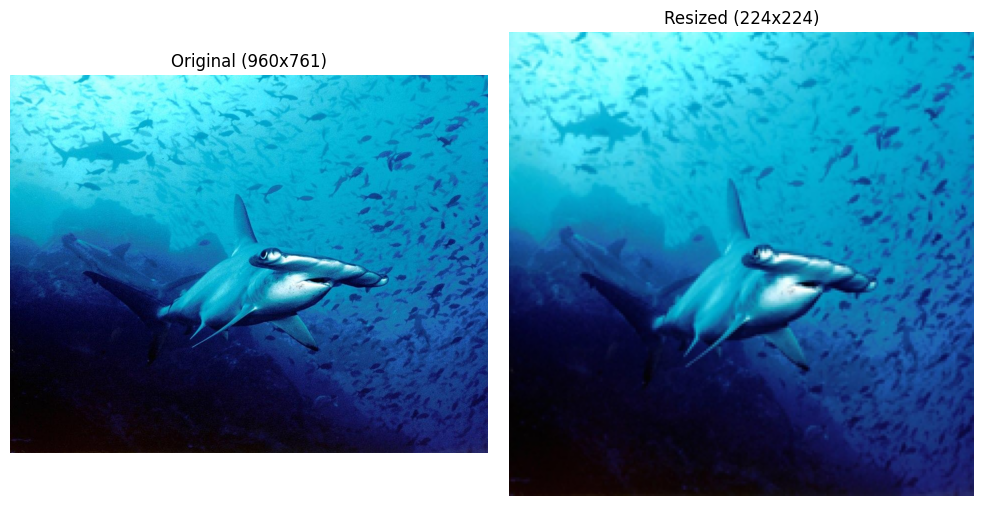

In [4]:
# Download a sample image if needed
sample_url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
image_path = "sample_image.jpg"

if not os.path.exists(image_path):
    print(f"Downloading sample image...")
    urllib.request.urlretrieve(sample_url, image_path)
    print(f"✓ Image saved as {image_path}")

# Load and display
img = load_image(image_path, size=224)

In [5]:
# Load pre-trained VGG16 model
print("Loading VGG16 model...")
model = models.vgg16(pretrained=True)
model.to(device)
model.eval()

print("\n✓ Model loaded!")
print(f"\nModel Architecture:")
print(f"  - Feature extractor: {len(model.features)} layers")
print(f"  - Classifier: {len(model.classifier)} layers")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Loading VGG16 model...


c:\Users\mahah\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\mahah\anaconda\envs\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



✓ Model loaded!

Model Architecture:
  - Feature extractor: 31 layers
  - Classifier: 7 layers
  - Total parameters: 138,357,544


###  Understanding VGG16 Architecture

VGG16 consists of:
1. **Features** (Convolutional layers): Extract spatial features
2. **Classifier** (Fully connected layers): Make final predictions

Let's visualize the layer structure:

In [6]:
# Display convolutional layers
print("\n" + "="*60)
print("CONVOLUTIONAL LAYERS:")
print("="*60)

conv_idx = 0
for idx, layer in enumerate(model.features):
    if isinstance(layer, nn.Conv2d):
        conv_idx += 1
        print(f"Conv{conv_idx:2d} (Layer {idx:2d}): {layer.in_channels:3d} → {layer.out_channels:3d} channels")
    elif isinstance(layer, nn.MaxPool2d):
        print(f"         Layer {idx:2d}: MaxPool (spatial downsampling)")

print(f"\nTarget layer for GradCAM: features[{28}] (last conv layer before final pooling)")


CONVOLUTIONAL LAYERS:
Conv 1 (Layer  0):   3 →  64 channels
Conv 2 (Layer  2):  64 →  64 channels
         Layer  4: MaxPool (spatial downsampling)
Conv 3 (Layer  5):  64 → 128 channels
Conv 4 (Layer  7): 128 → 128 channels
         Layer  9: MaxPool (spatial downsampling)
Conv 5 (Layer 10): 128 → 256 channels
Conv 6 (Layer 12): 256 → 256 channels
Conv 7 (Layer 14): 256 → 256 channels
         Layer 16: MaxPool (spatial downsampling)
Conv 8 (Layer 17): 256 → 512 channels
Conv 9 (Layer 19): 512 → 512 channels
Conv10 (Layer 21): 512 → 512 channels
         Layer 23: MaxPool (spatial downsampling)
Conv11 (Layer 24): 512 → 512 channels
Conv12 (Layer 26): 512 → 512 channels
Conv13 (Layer 28): 512 → 512 channels
         Layer 30: MaxPool (spatial downsampling)

Target layer for GradCAM: features[28] (last conv layer before final pooling)


In [7]:
# Replace in-place ReLU with out-of-place ReLU
# This is necessary for gradient computation in GradCAM

def replace_relu_inplace(model):
    """
    Replace all in-place ReLU activations with out-of-place versions.
    
    Why? In-place operations can cause issues with gradient computation
    because they modify the input tensor directly, making it impossible
    to backpropagate through them properly.
    """
    count = 0
    for name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, name, nn.ReLU(inplace=False))
            count += 1
        else:
            count += replace_relu_inplace(child)
    return count

num_replaced = replace_relu_inplace(model)
print(f"✓ Replaced {num_replaced} in-place ReLU activations")
print("  This ensures gradients can flow properly for GradCAM!")

✓ Replaced 15 in-place ReLU activations
  This ensures gradients can flow properly for GradCAM!


In [8]:
# Get predictions
img_tensor = preprocess_image(img).to(device)

with torch.no_grad():
    output = model(img_tensor)

# Load ImageNet labels and display predictions
imagenet_classes = get_imagenet_labels()
predicted_class = display_top_predictions(output, imagenet_classes, n=5)


Top-5 Predictions:
1. hammerhead                     |██████████████████████████░░░░░░░░░░░░░░| 65.45%
2. great white shark              |████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░| 21.91%
3. tiger shark                    |██░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░|  7.06%
4. electric ray                   |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░|  1.46%
5. scuba diver                    |░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░|  1.16%



---
## 4. Step 1: Capture Activations (Forward Hook)

### What are Activations?
Activations are the outputs of convolutional layers. They represent **what the network sees** at different spatial locations.

### Forward Hooks
PyTorch hooks allow us to intercept and save layer outputs during the forward pass.

In [9]:
# Storage for activations
activations = {}

def get_activation(name):
    """
    Creates a hook function that saves activations.
    
    Args:
        name: Identifier for this hook
    
    Returns:
        Hook function
    """
    def hook(module, input, output):
        # Detach from computation graph and move to CPU
        activations[name] = output.detach().cpu()
    return hook

# Register hook on the last convolutional layer
target_layer = model.features[28]  # Last conv layer in VGG16
hook_handle = target_layer.register_forward_hook(get_activation('conv_last'))

# Forward pass to capture activations
print("Running forward pass to capture activations...")
with torch.no_grad():
    _ = model(img_tensor)

# Get activations
act = activations['conv_last'].squeeze().numpy()

print(f"\n✓ Activations captured!")
print(f"  Shape: {act.shape}")
print(f"  Interpretation: {act.shape[0]} feature maps of size {act.shape[1]}x{act.shape[2]}")
print(f"  Value range: [{act.min():.3f}, {act.max():.3f}]")

# Remove hook
hook_handle.remove()

Running forward pass to capture activations...

✓ Activations captured!
  Shape: (512, 14, 14)
  Interpretation: 512 feature maps of size 14x14
  Value range: [-20.176, 16.915]


### Visualize Activation Maps

Let's look at what individual feature maps are detecting:

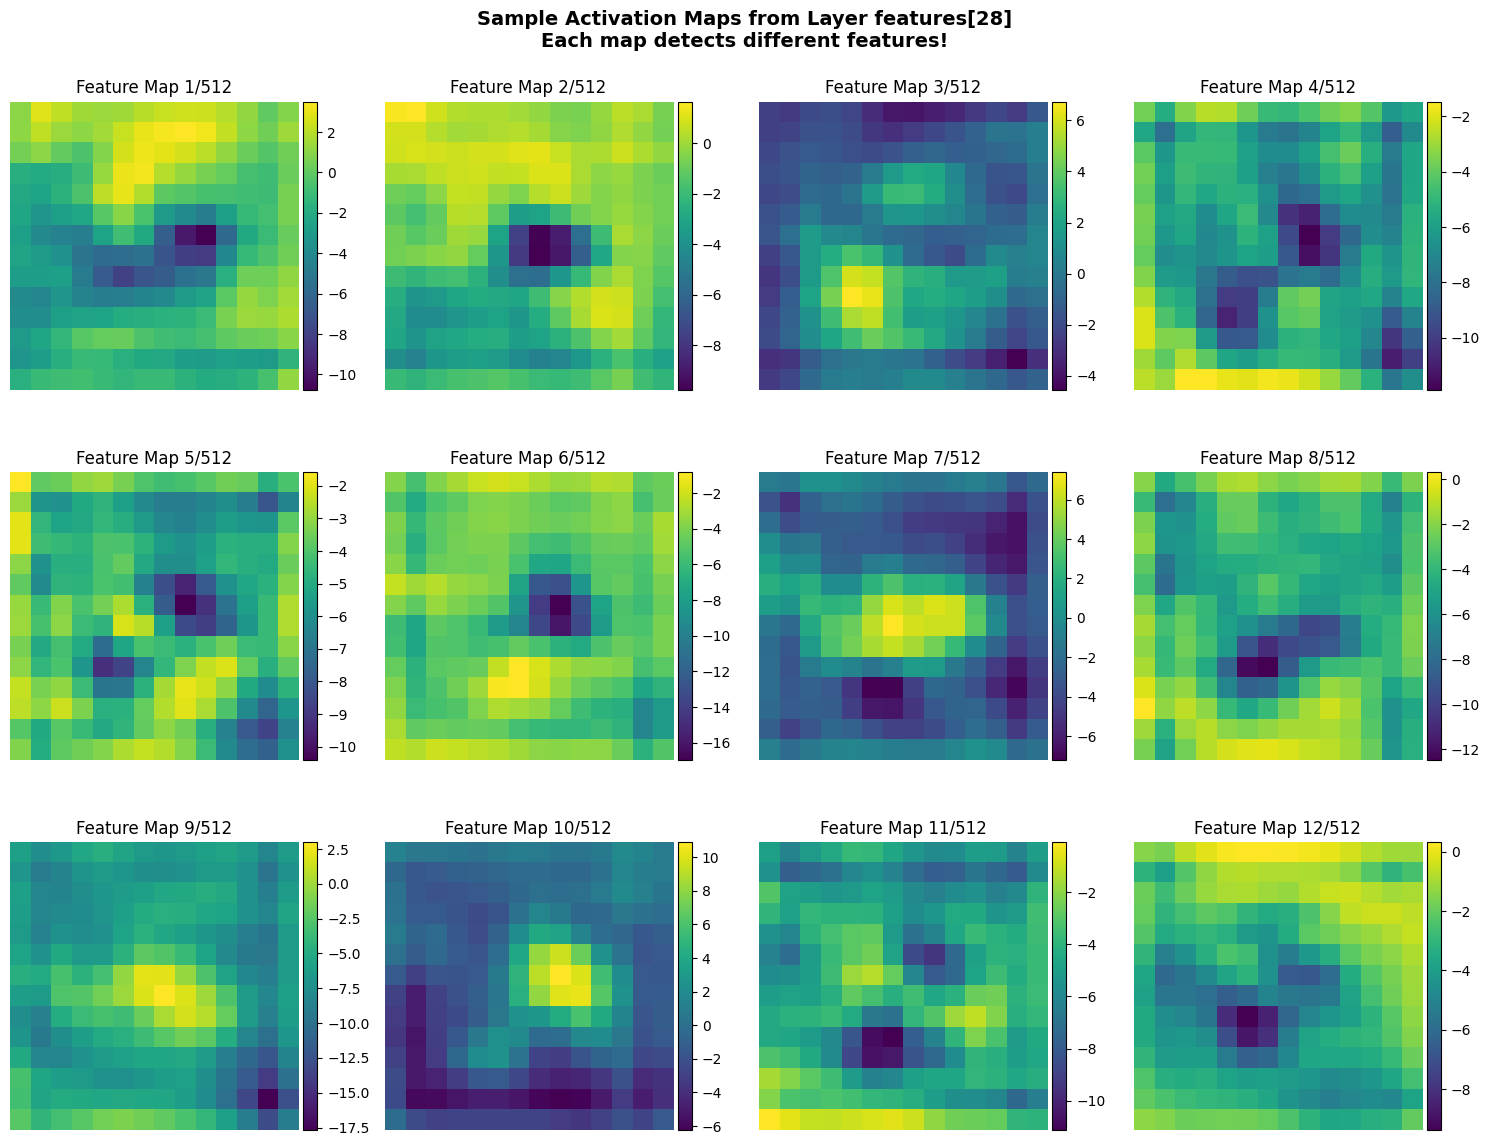


🔍 Observations:
  - Different feature maps activate in different regions
  - Some are sensitive to edges, others to textures
  - Brighter areas indicate stronger activations


In [ ]:
# Visualize first 12 activation maps
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    im = ax.imshow(act[i], cmap='viridis')
    ax.set_title(f"Feature Map {i+1}/{act.shape[0]}")
    ax.axis('off')
    
    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.suptitle(f"Sample Activation Maps from Layer features[28]\nEach map detects different features!", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n Observations:")
print("  - Different feature maps activate in different regions")
print("  - Some are sensitive to edges, others to textures")
print("  - Brighter areas indicate stronger activations")


Activation Statistics:


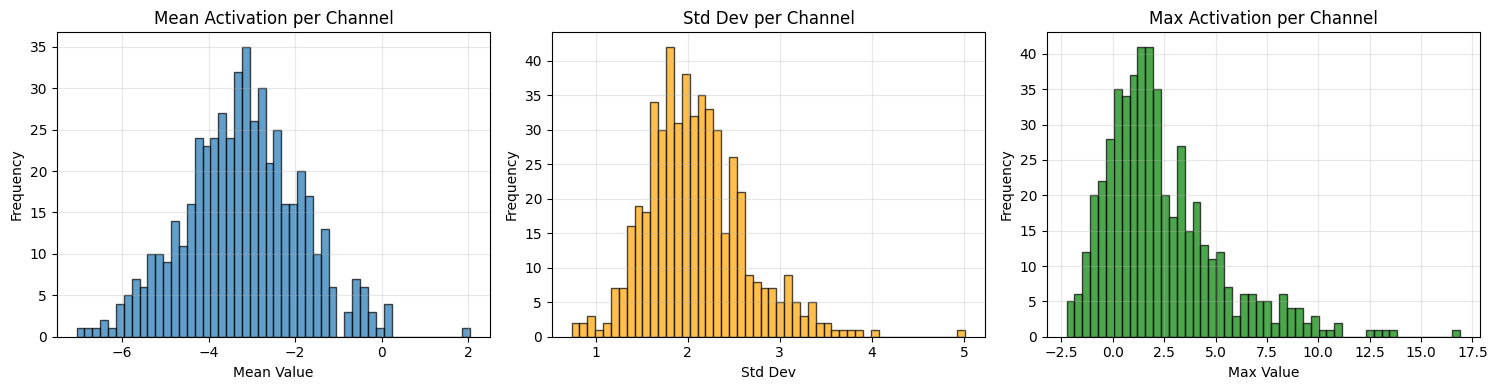


Most active channels (top 5):
  1. Channel 323: mean=2.052, max=7.594
  2. Channel 468: mean=0.215, max=7.340
  3. Channel 22: mean=0.215, max=5.564
  4. Channel 280: mean=0.135, max=4.762
  5. Channel 237: mean=0.123, max=7.805


In [11]:
# Analyze activation statistics
print("\nActivation Statistics:")
print("="*60)

# Per-channel statistics
channel_means = act.mean(axis=(1, 2))
channel_stds = act.std(axis=(1, 2))
channel_maxs = act.max(axis=(1, 2))

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(channel_means, bins=50, alpha=0.7, edgecolor='black')
axes[0].set_title('Mean Activation per Channel')
axes[0].set_xlabel('Mean Value')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.3)

axes[1].hist(channel_stds, bins=50, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title('Std Dev per Channel')
axes[1].set_xlabel('Std Dev')
axes[1].set_ylabel('Frequency')
axes[1].grid(alpha=0.3)

axes[2].hist(channel_maxs, bins=50, alpha=0.7, edgecolor='black', color='green')
axes[2].set_title('Max Activation per Channel')
axes[2].set_xlabel('Max Value')
axes[2].set_ylabel('Frequency')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMost active channels (top 5):")
top_channels = np.argsort(channel_means)[::-1][:5]
for rank, ch in enumerate(top_channels, 1):
    print(f"  {rank}. Channel {ch}: mean={channel_means[ch]:.3f}, max={channel_maxs[ch]:.3f}")

---
## 5. Step 2: Capture Gradients (Backward Hook)

### What are Gradients?
Gradients tell us **how much each activation influences the target class score**.

### Mathematical Formulation:
$$\frac{\partial y^c}{\partial A^k_{ij}}$$

This tells us: "How much does activation $A^k$ at position $(i,j)$ affect the score for class $c$?"

In [12]:
# Storage for gradients
gradients = {}

def get_gradient(name):
    """
    Creates a hook function that saves gradients.
    
    Args:
        name: Identifier for this hook
    
    Returns:
        Hook function
    """
    def hook(module, grad_input, grad_output):
        # Save the gradient of the output
        gradients[name] = grad_output[0].detach().cpu()
    return hook

# Register hooks
activation_hook = target_layer.register_forward_hook(get_activation('conv_last'))
gradient_hook = target_layer.register_full_backward_hook(get_gradient('conv_last'))

# Forward pass (requires gradients!)
print("Running forward pass...")
img_tensor.requires_grad_(True)
output = model(img_tensor)

# Get the score for the predicted class
target_score = output[0, predicted_class]

print(f"\nBackpropagating from class '{imagenet_classes[predicted_class]}'...")
print(f"  Class score: {target_score.item():.3f}")

# Backward pass
model.zero_grad()
target_score.backward()

# Get gradients
grads = gradients['conv_last'].squeeze().numpy()

print(f"\n✓ Gradients captured!")
print(f"  Shape: {grads.shape}")
print(f"  Value range: [{grads.min():.3f}, {grads.max():.3f}]")

# Remove hooks
activation_hook.remove()
gradient_hook.remove()

Running forward pass...

Backpropagating from class 'hammerhead'...
  Class score: 15.221

✓ Gradients captured!
  Shape: (512, 14, 14)
  Value range: [-0.028, 0.059]


### Visualize Gradients

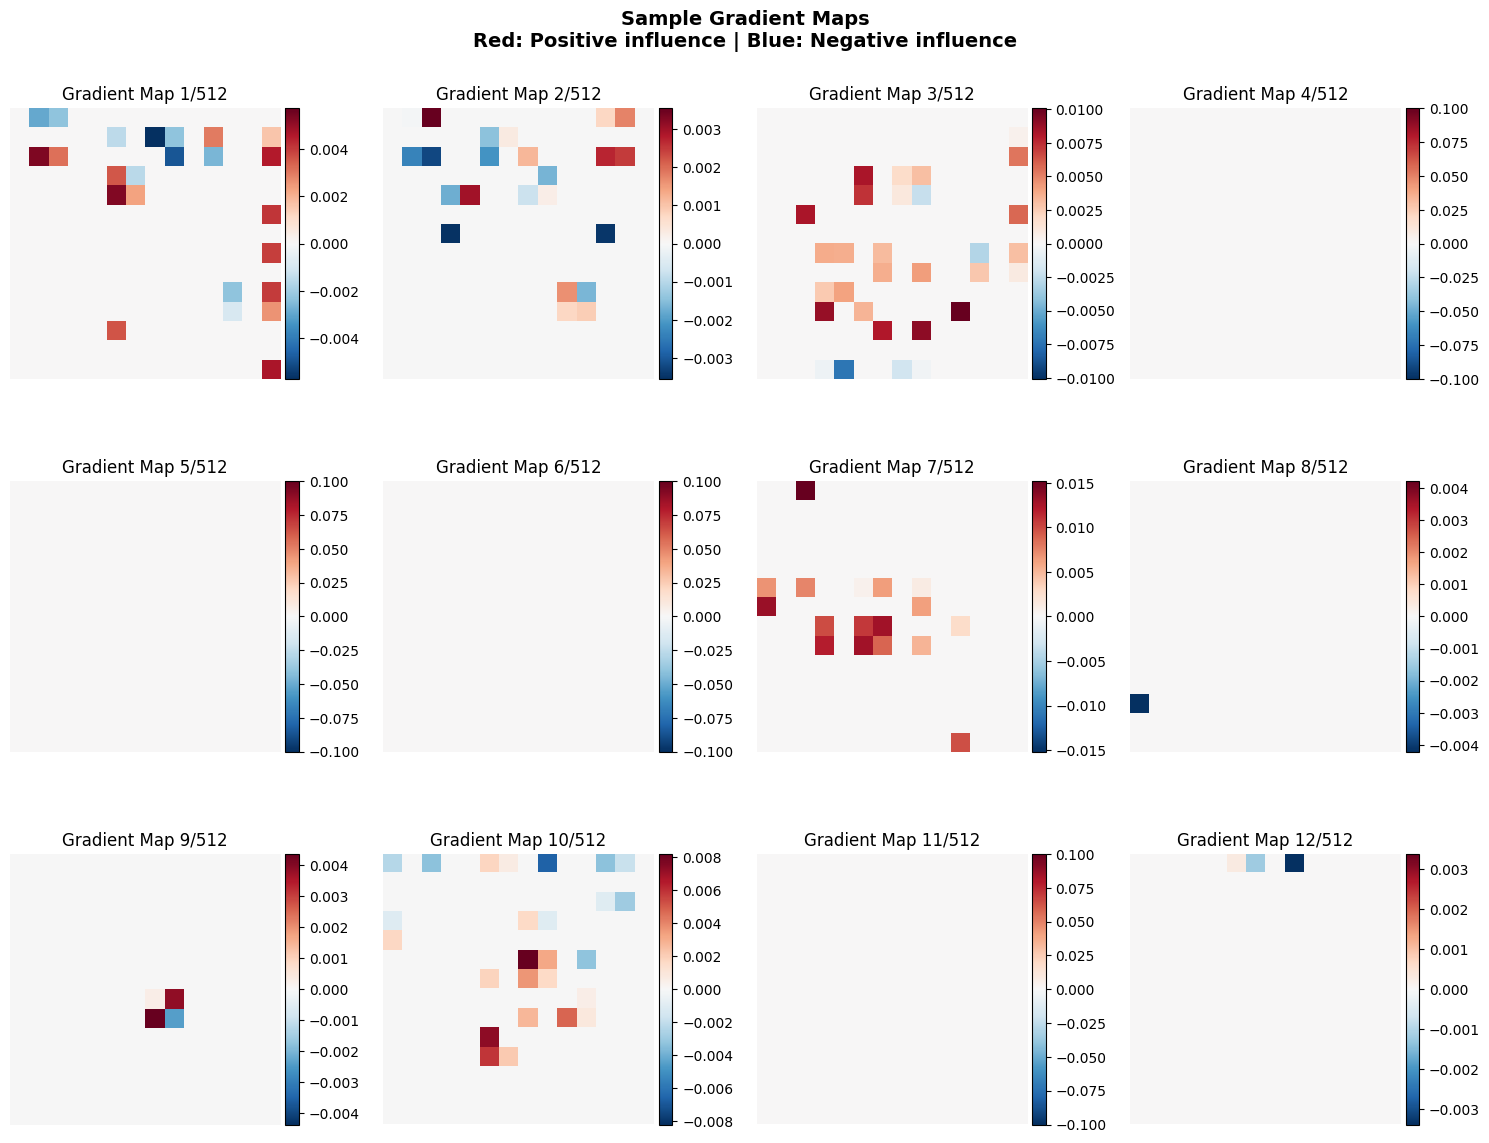


🔍 Observations:
  - Red regions: Increasing activation here INCREASES the class score
  - Blue regions: Increasing activation here DECREASES the class score
  - White regions: No significant influence


In [13]:
# Visualize first 12 gradient maps
fig, axes = plt.subplots(3, 4, figsize=(15, 12))
axes = axes.flatten()

for i in range(12):
    ax = axes[i]
    # Use diverging colormap (red-white-blue)
    vmax = max(abs(grads[i].min()), abs(grads[i].max()))
    im = ax.imshow(grads[i], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    ax.set_title(f"Gradient Map {i+1}/{grads.shape[0]}")
    ax.axis('off')
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.suptitle(f"Sample Gradient Maps\nRed: Positive influence | Blue: Negative influence", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Observations:")
print("  - Red regions: Increasing activation here INCREASES the class score")
print("  - Blue regions: Increasing activation here DECREASES the class score")
print("  - White regions: No significant influence")

---
## 6. Step 3: Compute Importance Weights (α)

### Global Average Pooling

$$\alpha^c_k = \frac{1}{Z}\sum_i \sum_j \frac{\partial y^c}{\partial A^k_{ij}}$$

This averages the gradients spatially to get a single importance value per channel.

In [14]:
# Step 1: Global Average Pooling on gradients
weights = np.mean(grads, axis=(1, 2))  # Average over spatial dimensions

print(f"Importance Weights (α):")
print(f"  Shape: {weights.shape}")
print(f"  Range: [{weights.min():.3f}, {weights.max():.3f}]")
print(f"\n  Interpretation: One weight per feature map")
print(f"  Positive weights → features that support the prediction")
print(f"  Negative weights → features that oppose the prediction")

Importance Weights (α):
  Shape: (512,)
  Range: [-0.001, 0.004]

  Interpretation: One weight per feature map
  Positive weights → features that support the prediction
  Negative weights → features that oppose the prediction


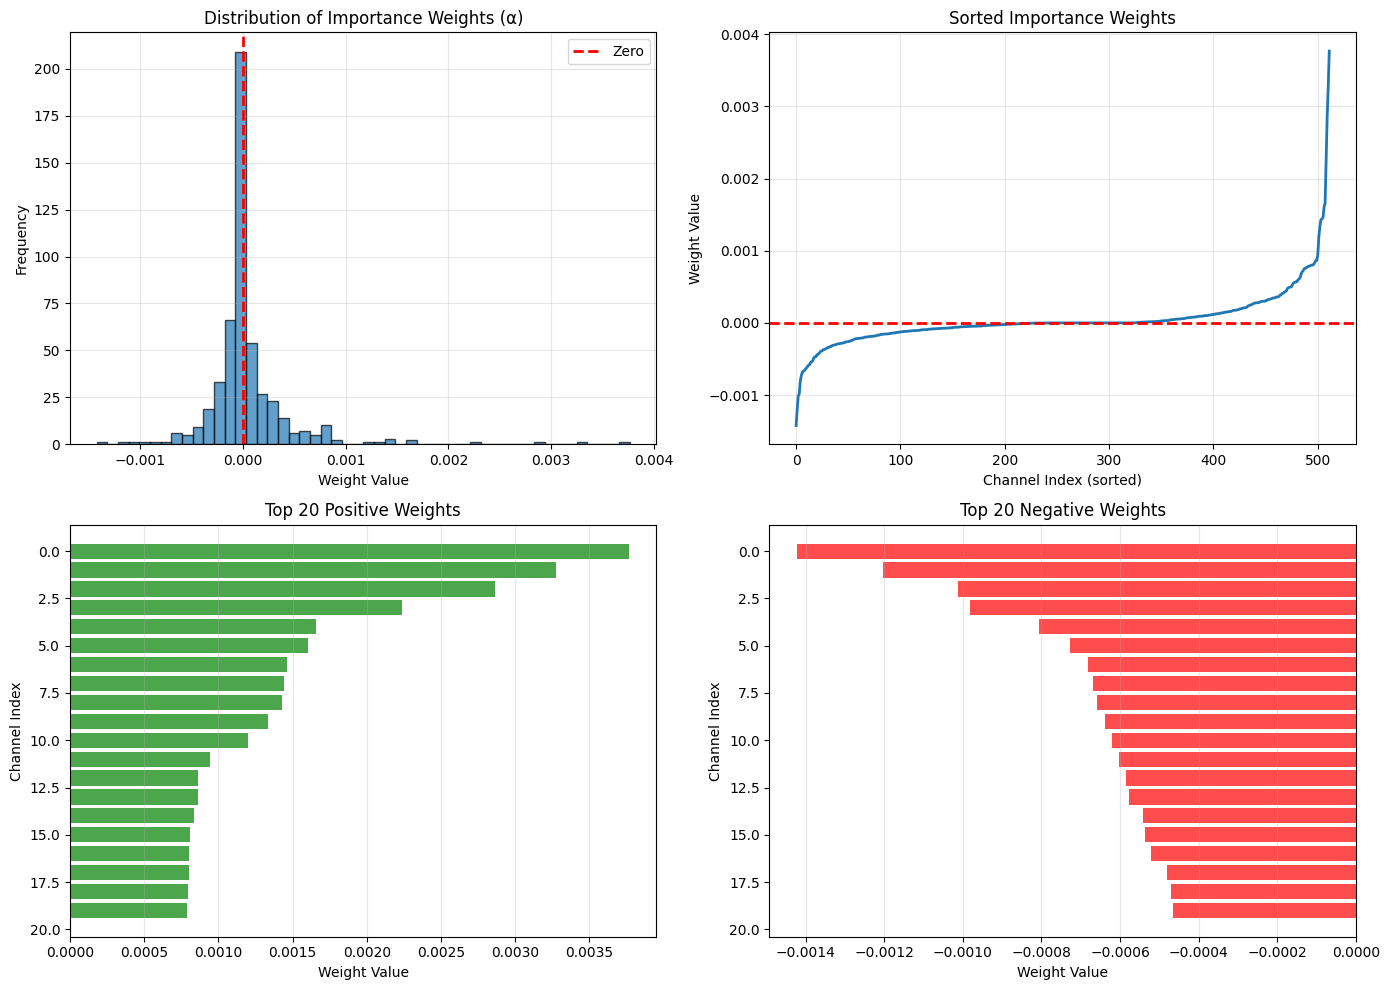


Weight Statistics:
  Positive weights: 188/512 (36.7%)
  Negative weights: 234/512 (45.7%)
  Mean: 0.0000
  Std: 0.0004


In [15]:
# Visualize importance weights
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram
axes[0, 0].hist(weights, bins=50, alpha=0.7, edgecolor='black')
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0, 0].set_title('Distribution of Importance Weights (α)')
axes[0, 0].set_xlabel('Weight Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Sorted weights
sorted_weights = np.sort(weights)
axes[0, 1].plot(sorted_weights, linewidth=2)
axes[0, 1].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0, 1].set_title('Sorted Importance Weights')
axes[0, 1].set_xlabel('Channel Index (sorted)')
axes[0, 1].set_ylabel('Weight Value')
axes[0, 1].grid(alpha=0.3)

# Top positive weights
top_positive_idx = np.argsort(weights)[::-1][:20]
axes[1, 0].barh(range(20), weights[top_positive_idx], color='green', alpha=0.7)
axes[1, 0].set_title('Top 20 Positive Weights')
axes[1, 0].set_xlabel('Weight Value')
axes[1, 0].set_ylabel('Channel Index')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(alpha=0.3, axis='x')

# Top negative weights
top_negative_idx = np.argsort(weights)[:20]
axes[1, 1].barh(range(20), weights[top_negative_idx], color='red', alpha=0.7)
axes[1, 1].set_title('Top 20 Negative Weights')
axes[1, 1].set_xlabel('Weight Value')
axes[1, 1].set_ylabel('Channel Index')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Statistics
print(f"\nWeight Statistics:")
print(f"  Positive weights: {(weights > 0).sum()}/{len(weights)} ({(weights > 0).sum()/len(weights)*100:.1f}%)")
print(f"  Negative weights: {(weights < 0).sum()}/{len(weights)} ({(weights < 0).sum()/len(weights)*100:.1f}%)")
print(f"  Mean: {weights.mean():.4f}")
print(f"  Std: {weights.std():.4f}")

---
## 7. Step 4: Weighted Combination

$$L^c = \sum_k \alpha^c_k A^k$$

Combine activation maps using the importance weights.

In [16]:
# Weighted combination
cam = np.zeros(act.shape[1:], dtype=np.float32)

for i, w in enumerate(weights):
    cam += w * act[i]

print(f"\nWeighted Activation Map:")
print(f"  Shape: {cam.shape}")
print(f"  Range: [{cam.min():.3f}, {cam.max():.3f}]")


Weighted Activation Map:
  Shape: (14, 14)
  Range: [-0.085, 0.075]


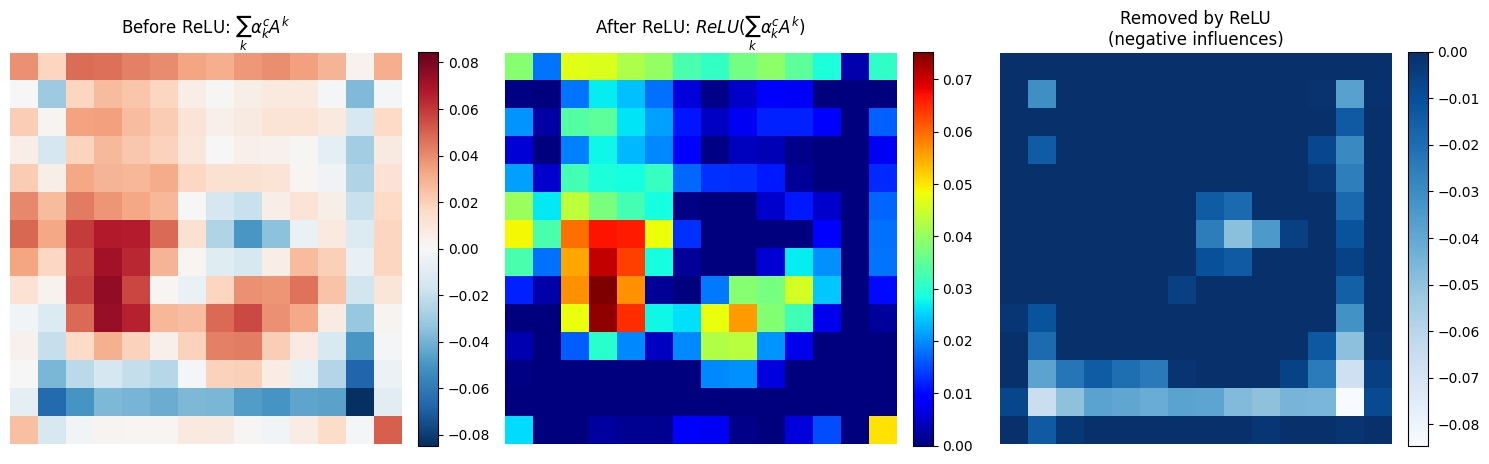


✓ ReLU applied!
  Before ReLU: 58/196 negative values (29.6%)
  After ReLU: 0/196 negative values (0%)

  Why ReLU? We only want features that POSITIVELY influence the prediction!


In [17]:
# Visualize before and after ReLU
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Before ReLU
vmax = max(abs(cam.min()), abs(cam.max()))
im1 = axes[0].imshow(cam, cmap='RdBu_r', vmin=-vmax, vmax=vmax)
axes[0].set_title(r'Before ReLU: $\sum_k \alpha^c_k A^k$')
axes[0].axis('off')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# After ReLU
cam_relu = np.maximum(cam, 0)
im2 = axes[1].imshow(cam_relu, cmap='jet')
axes[1].set_title(r'After ReLU: $ReLU(\sum_k \alpha^c_k A^k)$')
axes[1].axis('off')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Difference
removed = cam - cam_relu
im3 = axes[2].imshow(removed, cmap='Blues')
axes[2].set_title('Removed by ReLU\n(negative influences)')
axes[2].axis('off')
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"\n✓ ReLU applied!")
print(f"  Before ReLU: {(cam < 0).sum()}/{cam.size} negative values ({(cam < 0).sum()/cam.size*100:.1f}%)")
print(f"  After ReLU: {(cam_relu < 0).sum()}/{cam_relu.size} negative values (0%)")
print(f"\n  Why ReLU? We only want features that POSITIVELY influence the prediction!")

---
## 8. Step 5: Upsample & Visualize

Resize the heatmap to match the original image size.

In [18]:
# Normalize to [0, 1]
cam_normalized = (cam_relu - cam_relu.min()) / (cam_relu.max() - cam_relu.min() + 1e-8)

# Upsample to original image size
cam_upsampled = cv2.resize(cam_normalized, (224, 224), interpolation=cv2.INTER_LINEAR)

print(f"Upsampled heatmap: {cam_upsampled.shape}")
print(f"Range: [{cam_upsampled.min():.3f}, {cam_upsampled.max():.3f}]")

Upsampled heatmap: (224, 224)
Range: [0.000, 0.992]


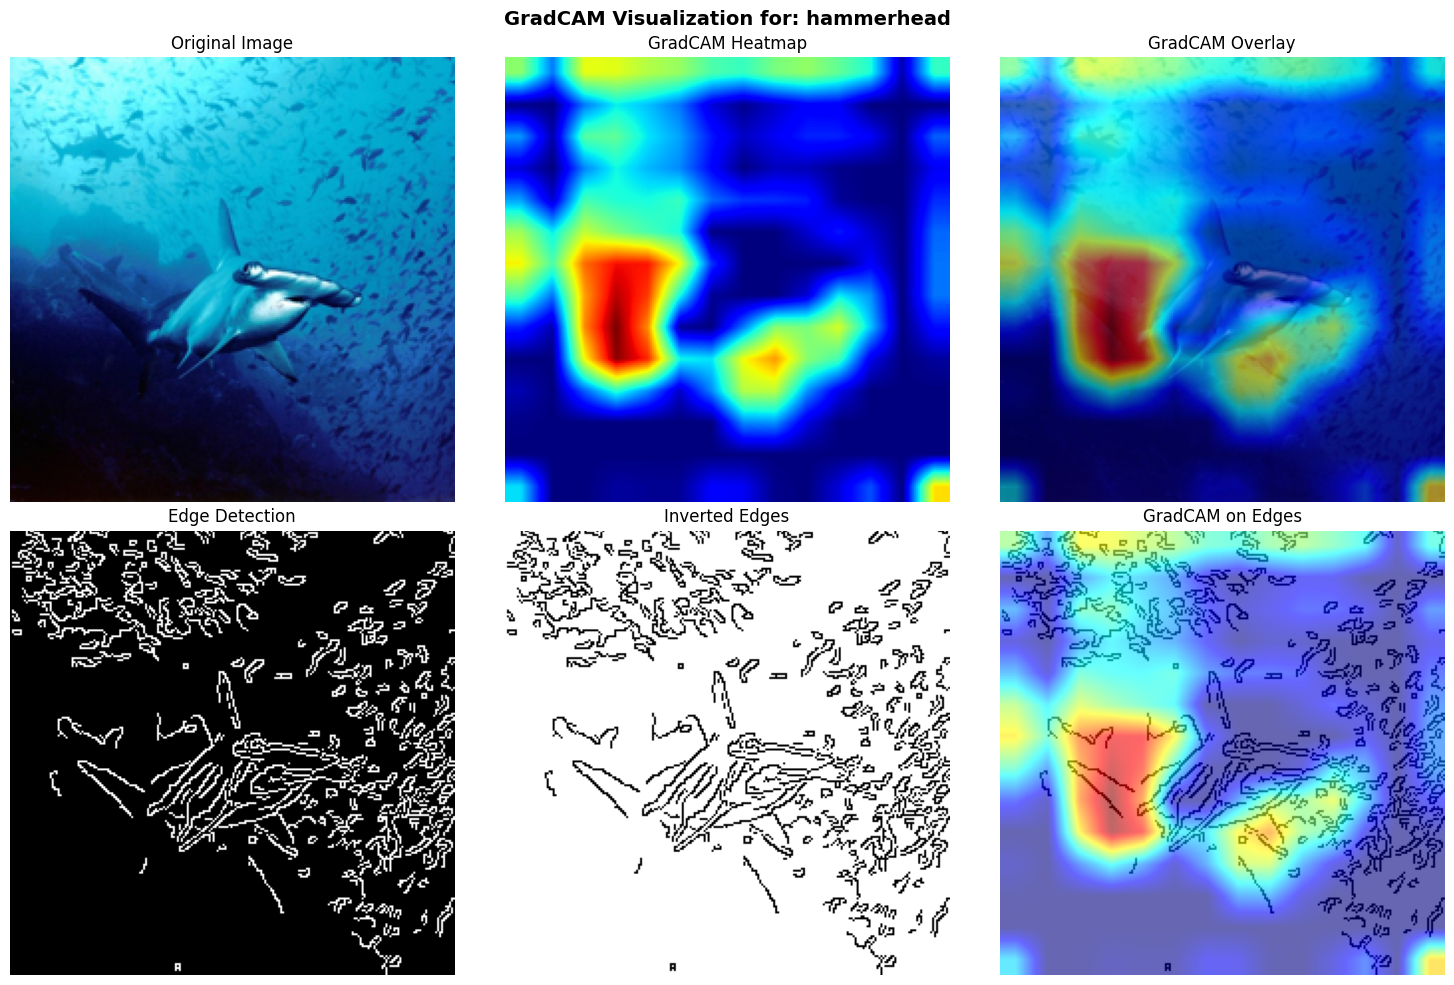

In [19]:
# Apply colormap
heatmap_colored = cv2.applyColorMap(np.uint8(255 * cam_upsampled), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

# Prepare original image
img_array = np.array(img) / 255.0
heatmap_colored = heatmap_colored / 255.0

# Blend
superimposed = 0.6 * heatmap_colored + 0.4 * img_array
superimposed = superimposed / superimposed.max()

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Row 1: Original, Heatmap, Overlay
axes[0, 0].imshow(img)
axes[0, 0].set_title(f"Original Image")
axes[0, 0].axis('off')

axes[0, 1].imshow(cam_upsampled, cmap='jet')
axes[0, 1].set_title("GradCAM Heatmap")
axes[0, 1].axis('off')

axes[0, 2].imshow(superimposed)
axes[0, 2].set_title("GradCAM Overlay")
axes[0, 2].axis('off')

# Row 2: Edge detection versions
edges = cv2.Canny(np.array(img), 100, 200)
edges_rgb = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB) / 255.0

axes[1, 0].imshow(edges, cmap='gray')
axes[1, 0].set_title("Edge Detection")
axes[1, 0].axis('off')

axes[1, 1].imshow(1 - edges / 255.0, cmap='gray')
axes[1, 1].set_title("Inverted Edges")
axes[1, 1].axis('off')

edge_overlay = 0.6 * heatmap_colored + 0.4 * (1 - edges_rgb)
axes[1, 2].imshow(edge_overlay)
axes[1, 2].set_title("GradCAM on Edges")
axes[1, 2].axis('off')

plt.suptitle(f"GradCAM Visualization for: {imagenet_classes[predicted_class]}", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## 9. Complete GradCAM Class Implementation

Now let's wrap everything into a reusable class!

In [21]:
class GradCAM:
    """
    Gradient-weighted Class Activation Mapping implementation.
    
    Paper: https://arxiv.org/abs/1610.02391
    """
    
    def __init__(self, model, target_layer):
        """
        Args:
            model: PyTorch model
            target_layer: Layer to extract activations and gradients from
        """
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        
        # Register hooks
        self.forward_hook = target_layer.register_forward_hook(self._save_activation)
        self.backward_hook = target_layer.register_full_backward_hook(self._save_gradient)
    
    def _save_activation(self, module, input, output):
        """Hook to save forward pass activations."""
        self.activations = output.detach()
    
    def _save_gradient(self, module, grad_input, grad_output):
        """Hook to save backward pass gradients."""
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_tensor, target_class=None):
        """
        Generate GradCAM heatmap.
        
        Args:
            input_tensor: Input image tensor (1, C, H, W)
            target_class: Target class index (if None, use predicted class)
        
        Returns:
            cam: GradCAM heatmap (H, W)
            prediction: Predicted class index
        """
        # Forward pass
        input_tensor = input_tensor.requires_grad_(True)
        output = self.model(input_tensor)
        
        # Get target class
        if target_class is None:
            target_class = output.argmax(dim=1).item()
        
        # Backward pass
        self.model.zero_grad()
        target_score = output[0, target_class]
        target_score.backward()
        
        # Get activations and gradients
        activations = self.activations.cpu().numpy()[0]  # (C, H, W)
        gradients = self.gradients.cpu().numpy()[0]      # (C, H, W)
        
        # Global average pooling of gradients
        weights = np.mean(gradients, axis=(1, 2))  # (C,)
        
        # Weighted combination
        cam = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            cam += w * activations[i]
        
        # ReLU
        cam = np.maximum(cam, 0)
        
        # Normalize
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam, target_class
    
    def visualize(self, input_tensor, img_pil, target_class=None, save_path=None):
        """
        Generate and visualize GradCAM.
        
        Args:
            input_tensor: Input tensor
            img_pil: Original PIL image
            target_class: Target class (if None, use predicted)
            save_path: Path to save visualization (optional)
        """
        # Generate CAM
        cam, pred_class = self.generate_cam(input_tensor, target_class)
        
        # Resize CAM to image size
        cam_resized = cv2.resize(cam, img_pil.size)
        
        # Apply colormap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        
        # Overlay
        img_array = np.array(img_pil) / 255.0
        overlay = 0.6 * heatmap + 0.4 * img_array
        overlay = overlay / overlay.max()
        
        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        axes[0].imshow(img_pil)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        axes[1].imshow(cam_resized, cmap='jet')
        axes[1].set_title("GradCAM Heatmap")
        axes[1].axis('off')
        
        axes[2].imshow(overlay)
        axes[2].set_title("Overlay")
        axes[2].axis('off')
        
        plt.suptitle(f"Class: {imagenet_classes[pred_class]}", fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
            print(f"✓ Saved to {save_path}")
        
        plt.show()
        
        return cam_resized, pred_class
    
    def __del__(self):
        """Remove hooks when object is destroyed."""
        self.forward_hook.remove()
        self.backward_hook.remove()

print("✓ GradCAM class defined!")

✓ GradCAM class defined!


✓ Saved to gradcam_result.png


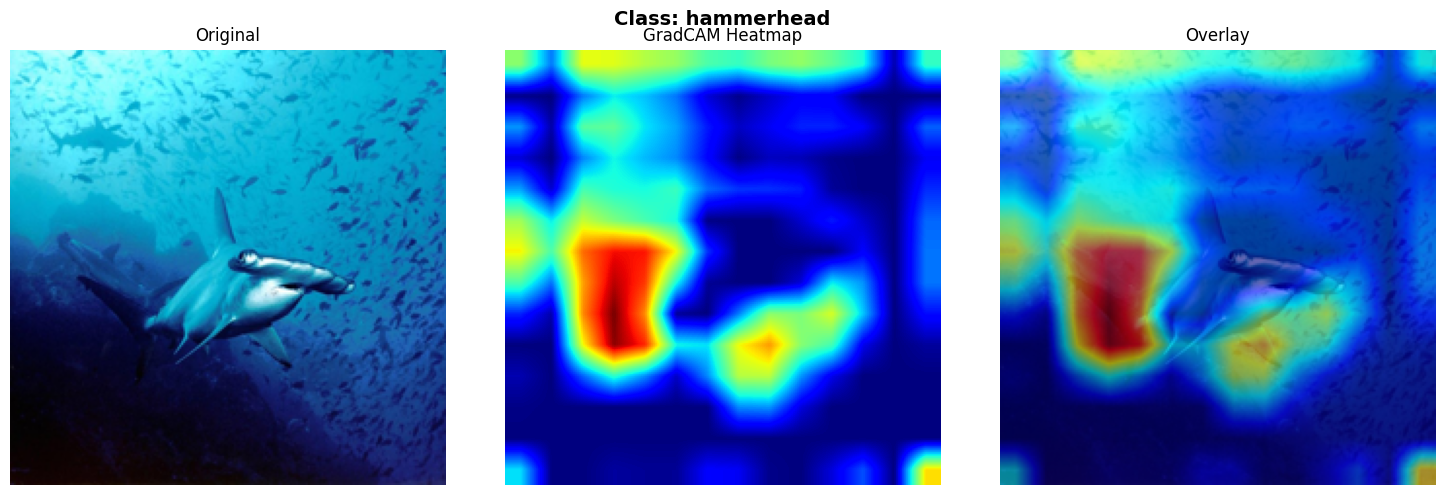

In [22]:
# Test the GradCAM class
gradcam = GradCAM(model, model.features[28])
cam, pred = gradcam.visualize(img_tensor, img, save_path='gradcam_result.png')

---
## 10. Multi-Layer Analysis

Compare GradCAM from different layers!

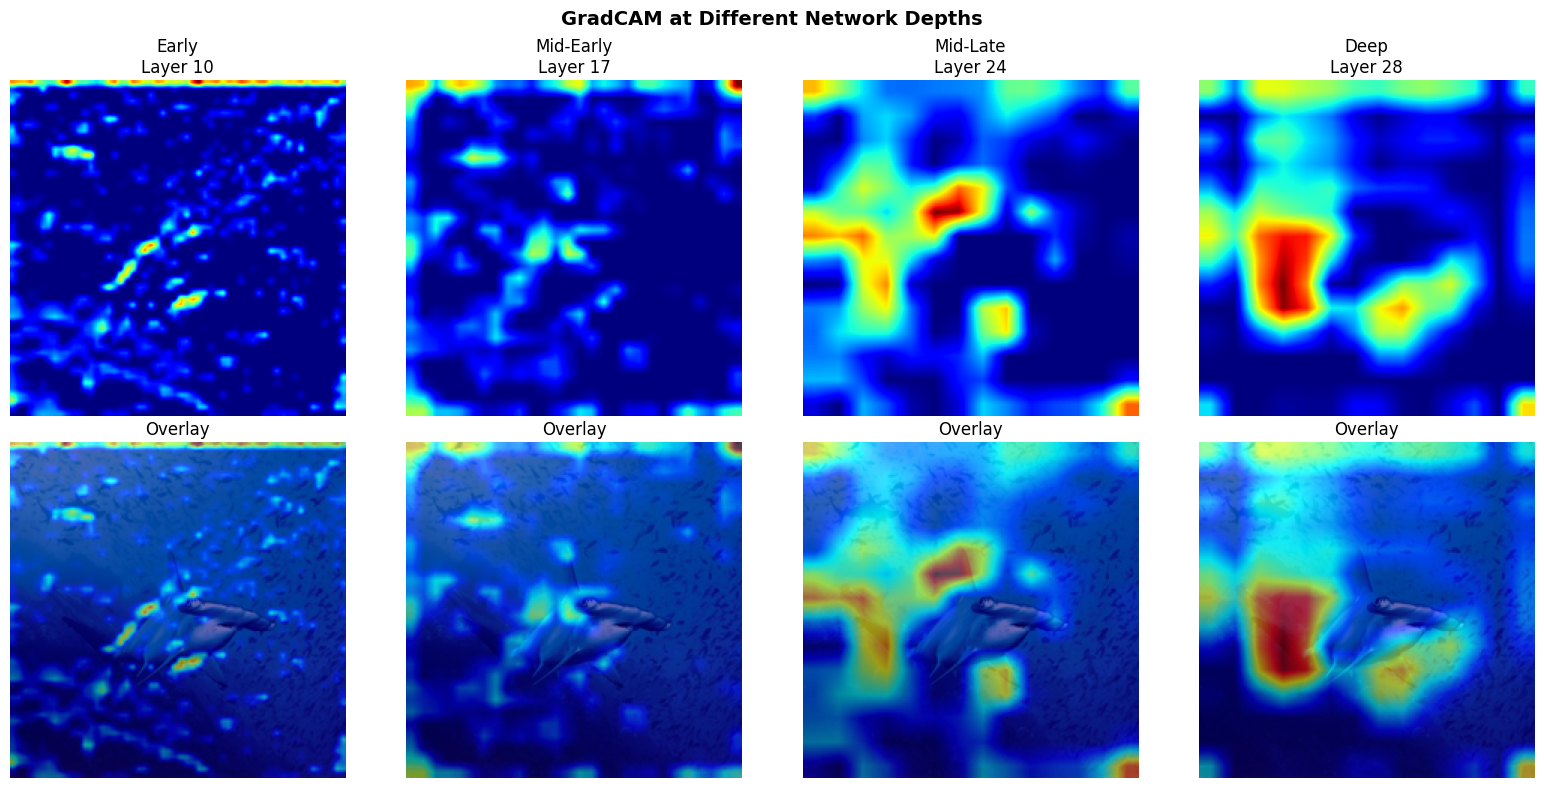


🔍 Key Observations:
  - Early layers: Focus on low-level features (edges, colors)
  - Later layers: Focus on high-level semantic regions
  - Deepest layer: Most class-specific localization


In [23]:
# Analyze multiple layers
layer_indices = [10, 17, 24, 28]  # Different conv layers in VGG16
layer_names = ['Early', 'Mid-Early', 'Mid-Late', 'Deep']

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for idx, (layer_idx, layer_name) in enumerate(zip(layer_indices, layer_names)):
    # Create GradCAM for this layer
    gradcam = GradCAM(model, model.features[layer_idx])
    cam, _ = gradcam.generate_cam(img_tensor)
    
    # Resize
    cam_resized = cv2.resize(cam, img.size)
    
    # Apply colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
    
    # Overlay
    img_array = np.array(img) / 255.0
    overlay = 0.6 * heatmap + 0.4 * img_array
    
    # Plot heatmap
    axes[0, idx].imshow(cam_resized, cmap='jet')
    axes[0, idx].set_title(f"{layer_name}\nLayer {layer_idx}")
    axes[0, idx].axis('off')
    
    # Plot overlay
    axes[1, idx].imshow(overlay)
    axes[1, idx].set_title(f"Overlay")
    axes[1, idx].axis('off')
    
    del gradcam

plt.suptitle("GradCAM at Different Network Depths", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Key Observations:")
print("  - Early layers: Focus on low-level features (edges, colors)")
print("  - Later layers: Focus on high-level semantic regions")
print("  - Deepest layer: Most class-specific localization")

---
## 11. Summary & Key Takeaways

### What We Learned:

1. **Activations** (Forward Pass)
   - Capture what the network "sees"
   - Different channels detect different features
   - Spatial information preserved

2. **Gradients** (Backward Pass)
   - Tell us feature importance
   - Computed via backpropagation
   - Class-specific information

3. **Importance Weights** (α)
   - Global average pooling of gradients
   - One weight per channel
   - Indicates channel relevance

4. **GradCAM Formula**
   $$L^c_{GradCAM} = ReLU\left(\sum_k \alpha^c_k A^k\right)$$
   - Weighted sum of activations
   - ReLU keeps positive influences
   - Class-discriminative localization

### Advantages:
- ✓ Works with any CNN architecture
- ✓ No architectural changes needed
- ✓ Class-discriminative
- ✓ Computationally efficient

### Applications:
- Model debugging & validation
- Understanding learned features
- Building trust in AI systems
- Detecting model biases